In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import h5py
import gc
import time

start = time.time()
gc.collect()  # Clear unused memory
torch.cuda.empty_cache()

In [2]:
# Load the .h5 file into memory once
h5_file_path_train = r"C:\Users\nadav.k\Documents\DS\DL_classification\classification_data\training.h5"
h5_file_path_test = r"C:\Users\nadav.k\Documents\DS\DL_classification\classification_data\testing.h5"

# Open the H5 files
h5_train = h5py.File(h5_file_path_train, 'r')
h5_test = h5py.File(h5_file_path_test, 'r')

# Extract datasets
train_sen1_data = h5_train['sen1']
#train_sen2_data = h5_train['sen2']
train_labels = h5_train['new_labels']

test_sen1_data = h5_test['sen1']
#test_sen2_data = h5_test['sen2']
test_labels = h5_test['new_labels']


In [3]:
class Sentinel1Dataset(Dataset):
    def __init__(self, sen1_data, labels):
        self.sen1_data = sen1_data
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        # Extract Sentinel-1 image and label
        sen1_image = self.sen1_data[idx]
        label = self.labels[idx]

        # Convert to PyTorch tensors
        sen1_image = torch.tensor(sen1_image, dtype=torch.float32).permute(2, 0, 1)

        # Convert one-hot encoded label to class index
        label = torch.tensor(label, dtype=torch.float32)
        label = torch.argmax(label).long()

        return sen1_image, label


In [4]:
# Create datasets
train_dataset = Sentinel1Dataset(train_sen1_data, train_labels)
test_dataset = Sentinel1Dataset(test_sen1_data, test_labels)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [5]:
class Sentinel1ConvNet(nn.Module):
    def __init__(self, num_classes=9):
        super(Sentinel1ConvNet, self).__init__()

        # Sentinel-1 branch
        self.conv1 = nn.Conv2d(8, 32, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(p=0.25)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc1_dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc2_dropout = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Sentinel-1 forward pass
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc1_dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_dropout(x)
        x = self.fc3(x)

        return x


In [6]:
# Training function with visualization and memory clearing
def train_model(model, train_loader, criterion, optimizer, num_epochs, device='cuda'):
    model.to(device)
    model.train()

    train_losses = []  # List to store training loss for visualization

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0

        for i, (sen1, labels) in enumerate(train_loader):
            sen1, labels = sen1.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sen1)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            epoch_loss += loss.item()

            # Clear memory for each batch (optional but not usually necessary here)
            del outputs, loss

            if i % 100 == 99:  # Print every 100 mini-batches
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                running_loss = 0.0

        # Average loss for the epoch
        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}] Average Loss: {epoch_loss:.4f}')

        # Clear unused memory after each epoch
        torch.cuda.empty_cache()  # Clear GPU memory
        gc.collect()  # Trigger garbage collection for CPU memory

    print('Training complete')

    # Visualization of training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()


In [7]:
def evaluate_model(model, test_loader, criterion, device='cuda'):
    model.to(device)
    model.eval()

    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for sen1, labels in test_loader:
            sen1, labels = sen1.to(device), labels.to(device)
            outputs = model(sen1)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate accuracy
            predicted = torch.argmax(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples

    print(f'Average Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Visualization (optional)
    plt.figure(figsize=(6, 4))
    plt.bar(['Loss', 'Accuracy'], [avg_loss, accuracy])
    plt.title('Evaluation Results')
    plt.ylabel('Value')
    plt.grid()
    plt.show()

    return avg_loss, accuracy


In [8]:
# Initialize model, loss function, and optimizer
model = Sentinel1ConvNet(num_classes=9)  # Adjust num_classes based on your dataset
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/50], Step [100/5013], Loss: 1.8074
Epoch [1/50], Step [200/5013], Loss: 1.5318
Epoch [1/50], Step [300/5013], Loss: 1.4269
Epoch [1/50], Step [400/5013], Loss: 1.3683
Epoch [1/50], Step [500/5013], Loss: 1.2941
Epoch [1/50], Step [600/5013], Loss: 1.2783
Epoch [1/50], Step [700/5013], Loss: 1.2619
Epoch [1/50], Step [800/5013], Loss: 1.2138
Epoch [1/50], Step [900/5013], Loss: 1.1875
Epoch [1/50], Step [1000/5013], Loss: 1.1614
Epoch [1/50], Step [1100/5013], Loss: 1.1264
Epoch [1/50], Step [1200/5013], Loss: 1.1470
Epoch [1/50], Step [1300/5013], Loss: 1.1238
Epoch [1/50], Step [1400/5013], Loss: 1.1060
Epoch [1/50], Step [1500/5013], Loss: 1.1020
Epoch [1/50], Step [1600/5013], Loss: 1.1039
Epoch [1/50], Step [1700/5013], Loss: 1.0654
Epoch [1/50], Step [1800/5013], Loss: 1.0846
Epoch [1/50], Step [1900/5013], Loss: 1.0502
Epoch [1/50], Step [2000/5013], Loss: 1.0604
Epoch [1/50], Step [2100/5013], Loss: 1.0384
Epoch [1/50], Step [2200/5013], Loss: 1.0754
Epoch [1/50], Step 

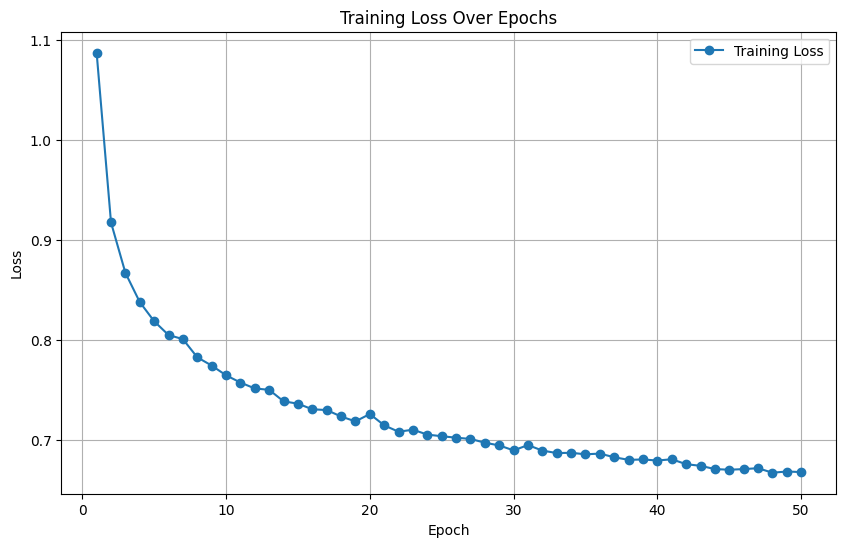

In [9]:
# Train the model
gc.collect()
train_model(model, train_loader, criterion, optimizer, num_epochs=50, device='cuda')

Average Test Loss: 0.8454, Accuracy: 0.6982


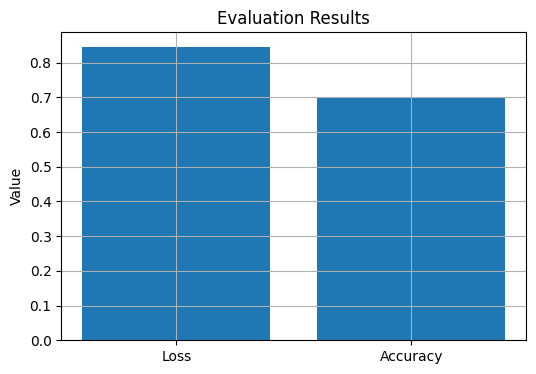

(0.8454493901509785, 0.6982001151525772)

In [10]:
# Perform evaluation
gc.collect()
evaluate_model(model, test_loader, criterion, device='cuda')

In [11]:
end = time.time()
print((end-start)//60)

86.0


In [12]:
torch.save(model.state_dict(), r"C:\Users\nadav.k\Documents\DS\DL_classification\saved_models\sentinal1_best_manuel_params_fulldata_new_labels.pth")